<p style="font-family:consolas; font-size: 28px; color: magenta"> GAN for generating MNIST digits in PyTorch</p>

In [2]:
'''
how to build a DCGAN for generating synthesis handwritten digit images by using MNIST dataset in PyTorch
'''
'''
GAN is a deep-learning-based generative model to create synthetic images, videos, music, and text with a real dataset
'''

'\nGAN is a deep-learning-based generative model to create synthetic images, videos, music, and text with a real dataset\n'

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Import libraries</p>

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Define variables</p>

In [14]:
CUDA = False
DATA_PATH = '../data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [15]:

if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Preparation the dataset</p>

In [16]:
'''
#MNIST dataset: A dataset of handwritten digits which contains 60,000 training images and 10,000 testing images.
#transforms.Resize: image size is changed from 28x28 to 64(X_DIM).
#transforms.ToTensor: Convert a PIL image or numpy.ndarray to tensor.
#transforms.Normalize: Normalize a tensor image with mean and standard deviation.
#Normalization ensures that the input data has a consistent scale,
#which can help models converge faster during training and improve performance
'''
dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,)) # mean and the standard deviation here and just used both 0.5.
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Plot training images</p>

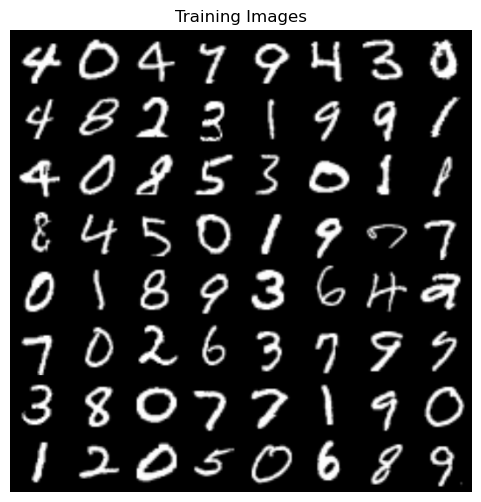

In [17]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Weight initialization</p>

In [18]:
'''
#The default weight initialization provided by PyTorch easily leads to saturation,
# so we need a custom weight initializer.
#From the DCGAN paper, the authors specify that all model weights
# shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.
'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Generator</p>

In [19]:
'''
#Input layer and hidden layers: Each layer consists of a strided two dimensional convolutional transpose layer,
# a 2d batch norm layer, and a relu activation.
#Output layer: it consists of a strided two dimensional convolutional transpose layer and a tanh function.
'''
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Discriminator</p>

In [20]:
'''
#Input layer: It consists of Conv2d and LeakyReLU.
#Hidden layer: It consists of Conv2d, BatchNorm2d, and LeakyReLU.
#Output layer: It consists of Conv2d and a sigmoid function.
'''
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4th layer
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Create the generator and the discriminator</p>

In [23]:
# Create the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Set up a loss function and optimizer</p>

In [24]:
'''
#Binary Cross Entropy loss (BCELoss) function is used for the loss function.
#ADAM is used for the optimizer.
'''
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Training</p>

In [14]:
'''
The goal of training the generator is to minimize log(1−D(G(z)))in an effort to generate better fakes,
which means to maximize log(D(G(z))).
'''
'''
The goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake,
which is log(D(x))+log(1−D(G(z))).
'''

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Update the discriminator with real data
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Update the discriminator with fake data
        # Generate batch of latent vectors
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (3) Update the generator with fake data
        netG.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 2.0992	Loss_G: 2.9477	D(x): 0.4106	D(G(z)): 0.5914 / 0.0720
[0/5][50/469]	Loss_D: 0.0123	Loss_G: 34.3600	D(x): 0.9936	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.9311	Loss_G: 6.7682	D(x): 0.5511	D(G(z)): 0.0005 / 0.0020
[0/5][150/469]	Loss_D: 0.3780	Loss_G: 11.3388	D(x): 0.9892	D(G(z)): 0.2874 / 0.0000
[0/5][200/469]	Loss_D: 0.1579	Loss_G: 3.4501	D(x): 0.9294	D(G(z)): 0.0736 / 0.0501
[0/5][250/469]	Loss_D: 0.2872	Loss_G: 2.9264	D(x): 0.8262	D(G(z)): 0.0510 / 0.0862
[0/5][300/469]	Loss_D: 0.9114	Loss_G: 3.6377	D(x): 0.6956	D(G(z)): 0.3366 / 0.0366
[0/5][350/469]	Loss_D: 0.1617	Loss_G: 3.5012	D(x): 0.9150	D(G(z)): 0.0592 / 0.0444
[0/5][400/469]	Loss_D: 1.1659	Loss_G: 1.3839	D(x): 0.4913	D(G(z)): 0.2164 / 0.2952
[0/5][450/469]	Loss_D: 0.5420	Loss_G: 1.4824	D(x): 0.6642	D(G(z)): 0.0726 / 0.2799
[1/5][0/469]	Loss_D: 0.2825	Loss_G: 2.4252	D(x): 0.8753	D(G(z)): 0.1245 / 0.1129
[1/5][50/469]	Loss_D: 0.2453	Loss_G: 2.6685	D(x): 0.8964	D(G(z))

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Real images and fake images</p>

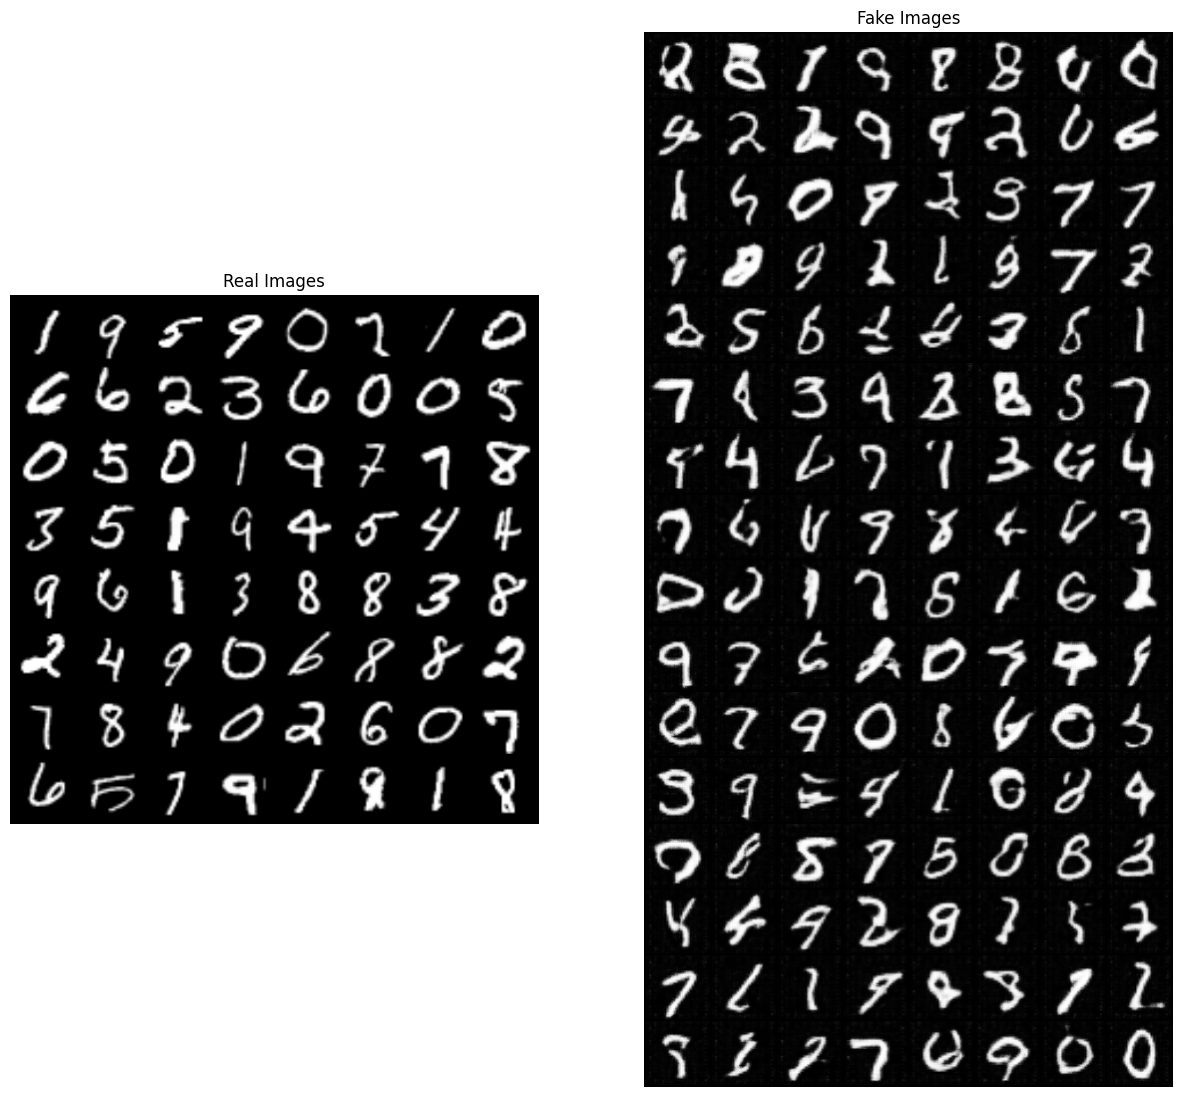

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()